## Facial Expression Classifier with CNN  

This notebook corresponds to the dataset and training conditions described in the report in section  
**"6) Dataset without Disgust and Neutral classes, balanced using class_weight, 5 classes + Post-training Binarization"**.  

In this notebook, I demonstrate how the incomplete dataset was used, in which the `Disgust` class (least represented) and the `Neutral` class (most confusing for the network) were removed. The resulting dataset with **5 classes ("Happy", "Surprise", "Angry", "Sad", "Fear")** is still unbalanced, so the **class_weight** parameter was applied during training. The model is then trained and evaluated using the metrics described below.  

Subsequently, the classification problem is **binarized**, grouping "Happy" and "Surprise" under the **"Positive"** label and "Angry", "Sad", "Fear" under the **"Negative"** label, after training. This allows evaluating the classification performance when the network is trained on a finer-grained class subdivision (**fine classes**). Metrics are computed to compare these results with those obtained in the **second notebook**, where the network is trained directly on a dataset already divided into two classes before training.



## Dataset Import and Pre-processing

The dataset was obtained from the following link:  
https://www.kaggle.com/msambare/fer2013  

In this section, the list of **class_weight** values to be used during training is also defined.  

Libraries will be imported multiple times to allow some notebook cells to run independently.


In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisco le directory
train_dir = "/Users/irenesilvestro/Desktop/quinto anno uni/reti_neurali/archive_copia_nodis_noneutral/train"
val_dir = "/Users/irenesilvestro/Desktop/quinto anno uni/reti_neurali/archive_copia_nodis_noneutral/validation"
test_dir = "/Users/irenesilvestro/Desktop/quinto anno uni/reti_neurali/archive_copia_nodis_noneutral/test"

# Funzione per contare gli elementi nelle sottocartelle
def count_images_in_subfolders(directory):
    if not os.path.exists(directory):
        print(f"La directory {directory} non esiste.")
        return
    
    print(f"\n Directory: {directory}")
    for subfolder in sorted(os.listdir(directory)):  # Ordina i nomi alfabeticamente (per leggerle nello stesso ordine)
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):  # Controlla se è una cartella
            count = len(os.listdir(subfolder_path))  # Conta i file
            print(f"  {subfolder}: {count} immagini")

# Conta i file nelle sottocartelle di train, validation e test
count_images_in_subfolders(train_dir)
count_images_in_subfolders(val_dir)
count_images_in_subfolders(test_dir)

2025-02-17 11:47:57.487474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



 Directory: /Users/irenesilvestro/Desktop/quinto anno uni/reti_neurali/archive_copia_nodis_noneutral/train
  angry: 3497 immagini
  fear: 3586 immagini
  happy: 6314 immagini
  sad: 4227 immagini
  surprise: 2776 immagini

 Directory: /Users/irenesilvestro/Desktop/quinto anno uni/reti_neurali/archive_copia_nodis_noneutral/validation
  angry: 958 immagini
  fear: 1024 immagini
  happy: 1774 immagini
  sad: 1247 immagini
  surprise: 831 immagini

 Directory: /Users/irenesilvestro/Desktop/quinto anno uni/reti_neurali/archive_copia_nodis_noneutral/test
  angry: 500 immagini
  fear: 513 immagini
  happy: 903 immagini
  sad: 605 immagini
  surprise: 397 immagini


Valore minimo: 0
Valore massimo: 255


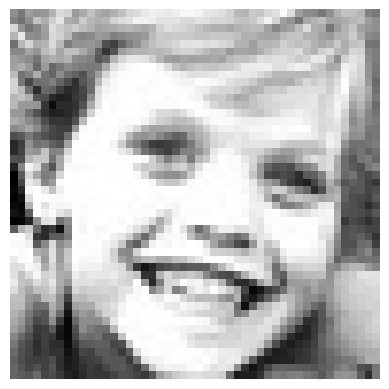

In [2]:
# Valutiamo il valore massimo e minimo assunti dai pixel nelle immagini del dataset per poter normalizzare correttamente 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Carica l'immagine
img = Image.open("PrivateTest_3447769.jpg")

# Convertiamo in array NumPy
img_array = np.array(img)

# Stampa i valori min e max dei pixel
print("Valore minimo:", img_array.min())
print("Valore massimo:", img_array.max())


# Mostra l'immagine nel notebook
plt.imshow(img, cmap="gray")  # Assicurati che venga mostrata in scala di grigi
plt.axis("off")  # Nasconde gli assi
plt.show()


In [3]:
# Preprocessing del dataset

#normalizzazione e data augumentation sul training set
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Random shift della larghezza delle immagini fino al 10%
    height_shift_range = 0.1,       # Random shift dell'altezza delle immagini fino al 10%
    horizontal_flip = True,         # Flip orizzontale delle immagini in modo casuale
    rescale = 1./255,               # Risacala il valore dei pixel tra 0 e 1 
)

#normalizzazione di validation set 
validation_datagen = ImageDataGenerator(
    rescale = 1./255,              
)

#normalizzazione di test set 
test_datagen = ImageDataGenerator(
    rescale = 1./255,               
)

In [4]:
# Caricamento del dataset 

#flow_from_directory() carica le immagini, preprocessate con ImageDataGenerator, li legge inoltre in ordine alfabetico 
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory che contiene i training data
    target_size = (48, 48),          # Per sicurezza ridimensioniammo tutte le immagini a 48x48 pixels
    batch_size = 64,                 # Impostiamo il numero di immagini per batch
    color_mode = "grayscale",        # Per sicurezza convertiamo le immagini in grayscale
    class_mode = "categorical",      # Impongo che le etichette delle immagini vengano convertite in one-hot encoding 
)

validation_generator = validation_datagen.flow_from_directory(
    directory = val_dir,            # Directory che contiene i validation data
    target_size = (48, 48), 
    batch_size = 64,                 
    color_mode = "grayscale",        
    class_mode = "categorical",   
)


test_generator = test_datagen.flow_from_directory(
    directory = test_dir,            
    target_size = (48, 48),          
    batch_size = 64,               
    color_mode = "grayscale",      
    class_mode = "categorical",     
)

Found 20395 images belonging to 5 classes.
Found 5834 images belonging to 5 classes.
Found 2913 images belonging to 5 classes.


In [5]:
# Essendo il dataset sbilanciato, nella fase di training andrò ad usare dei pesi personalizzati per ogni classe
# quindi qui calcolo i pesi per ogni classe tramite la libreria compute_class_weight

from sklearn.utils.class_weight import compute_class_weight

class_labels = np.array([0, 1, 2, 3, 4,])  # Indici delle classi
samples_per_class = np.array([3497, 3586, 6314, 4227, 2776])  # Numero di immagini per classe dei dati di training 


class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=np.repeat(class_labels, samples_per_class))
class_weights = dict(enumerate(class_weights))  # Converti in dizionario
print(class_weights)  # Stampa i pesi per verificare


{0: 1.1667143265656277, 1: 1.1377579475738986, 2: 0.6461830852074755, 3: 0.9652235628105039, 4: 1.4697406340057637}


## Network Architecture Definition and Training Setup


In [6]:
# Definisco il modello 

from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf 


model = Sequential()

# I Convolutional layer con 32 filters, 3x3 kernel size e relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
# I Batch normalization layer
model.add(BatchNormalization())
# II Convolutional layer con 64 filters, 3x3 kernel size e relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# II Batch normalization layer
model.add(BatchNormalization())
# Max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer con 0.25 dropout rate
model.add(Dropout(0.25))

# III Convolutional layer con 128 filters, 3x3 kernel size e relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# III Batch normalization layer
model.add(BatchNormalization())
# IV Convolutional layer con 128 filters, 3x3 kernel size e relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# IV Batch normalization layer
model.add(BatchNormalization())
# Max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))


# V Convolutional layer con 256 filters, 3x3 kernel size e relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# V Batch normalization layer
model.add(BatchNormalization())
# VI Convolutional layer con 256 filters, 3x3 kernel size e relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# VI Batch normalization layer
model.add(BatchNormalization())
# Max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten converte l' output degli strati convoluzionali
model.add(Flatten())
# Dense layer con 256 neuroni e relu activation function
model.add(Dense(256, activation='relu'))
# VII Batch normalization layer
model.add(BatchNormalization())
# Dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Dense layer con 5 neuroni (uno per ogni classe) e softmax come activation function
model.add(Dense(5, activation='softmax'))

# Compila il modello con  categorical cross-entropy loss, adam optimizer, learning rate fissato e accuracy metric
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Definisco per sicurezza il callback per salvare i pesi corrispondenti al miglior valore di val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights_prova_6.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)


# Avvio della fase di training 
history = model.fit(
    train_generator,   # Dataset di training con data augumentation
    steps_per_epoch=len(train_generator),   # Numero di batch di training set per ogni epoca 
    epochs=40,   # Stop criterium , numero di epoche 
    validation_data=validation_generator,   # Dataset di validation per monitorare il training 
    validation_steps=len(validation_generator),   #Numero di batch di validation set per ogni epoca 
    class_weight=class_weights,   #Uso i pesi per lo sbilanciamento del dataset 
    callbacks=[checkpoint_callback]   #richiamo la funzione sopra 
)



#Salva l'intero modello dell'ultima epoca (perchè ho visto che è comunque il migliore che si riesce a fare)
model.save('model_complete_prova_6.h5')  


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.2339 - loss: 2.5122
Epoch 1: val_accuracy improved from -inf to 0.30614, saving model to model_weights_prova_6.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 223s 680ms/step - accuracy: 0.2340 - loss: 2.5119 - val_accuracy: 0.3061 - val_loss: 1.7814
Epoch 2/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.2674 - loss: 2.1488
Epoch 2: val_accuracy improved from 0.30614 to 0.38173, saving model to model_weights_prova_6.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 198s 620ms/step - accuracy: 0.2674 - loss: 2.1487 - val_accuracy: 0.3817 - val_loss: 1.4584
Epoch 3/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.2980 - loss: 1.9721
Epoch 3: val_accuracy improved from 0.38173 to 0.41275, saving model to model_weights_prova_6.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 221s 692ms/step - accuracy: 0.2980 - loss: 1.9720 - val_accuracy: 0.4128 - val_loss: 1.4122
Epoch 4/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accur

Epoch 23/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5799 - loss: 1.0610
Epoch 23: val_accuracy improved from 0.60182 to 0.62479, saving model to model_weights_prova_6.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 202s 632ms/step - accuracy: 0.5799 - loss: 1.0611 - val_accuracy: 0.6248 - val_loss: 0.9568
Epoch 24/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5814 - loss: 1.0609
Epoch 24: val_accuracy did not improve from 0.62479
319/319 ━━━━━━━━━━━━━━━━━━━━ 202s 633ms/step - accuracy: 0.5814 - loss: 1.0609 - val_accuracy: 0.6174 - val_loss: 0.9646
Epoch 25/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5837 - loss: 1.0578
Epoch 25: val_accuracy improved from 0.62479 to 0.62496, saving model to model_weights_prova_6.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 201s 631ms/step - accuracy: 0.5837 - loss: 1.0578 - val_accuracy: 0.6250 - val_loss: 0.9509
Epoch 26/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.5901 - loss: 1.0331
Epoch 26: val_acc

## Loss and Accuracy on training and validation set

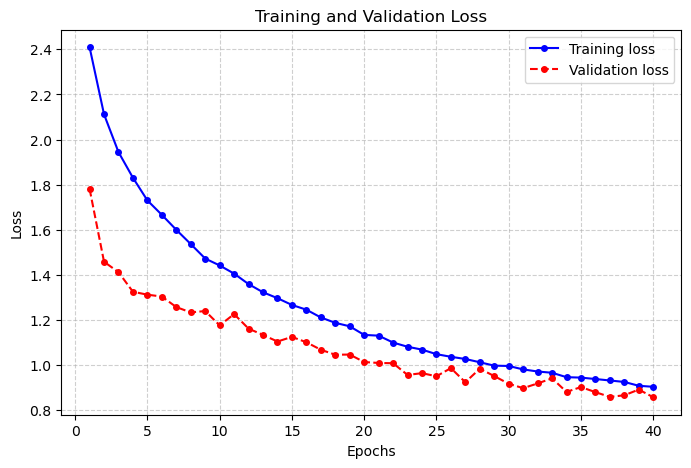

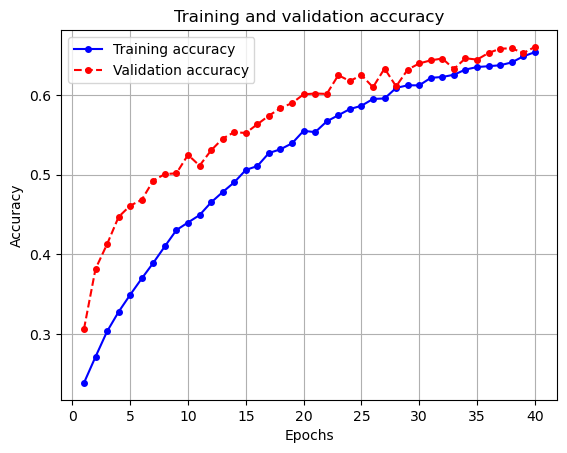

In [12]:
# Plot di Loss e Accuracy in funzione del numero di epoche sia del training che validation set

import matplotlib.pyplot as plt

# Estrazione dei dati di loss dal dizionario history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Creazione del plot
plt.figure(figsize=(8, 5))  
plt.plot(epochs, train_loss, 'bo-', markersize=4, label='Training loss')  # Linea blu con cerchi
plt.plot(epochs, val_loss, 'r--o', markersize=4, label='Validation loss')  # Linea rossa tratteggiata con cerchi

# Aggiunta griglia
plt.grid(True, linestyle='--', alpha=0.6)

# Titoli e assi
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostra il grafico
plt.show()


# Estrazione dei dati di loss dal dizionario history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Creazione del plot di accuracy
plt.plot(epochs, train_acc, 'bo-', markersize=4, label='Training accuracy')  # Linea blu con cerchi più piccoli
plt.plot(epochs, val_acc, 'r--o', markersize=4, label='Validation accuracy')  # Linea blu tratteggiata con cerchi più piccoli
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  
plt.show()

## Model Performance Evaluation
**-Confusion Matrix  
-Precision, Recall, f1-score  
-ROC curves  
-Saliency Map**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━

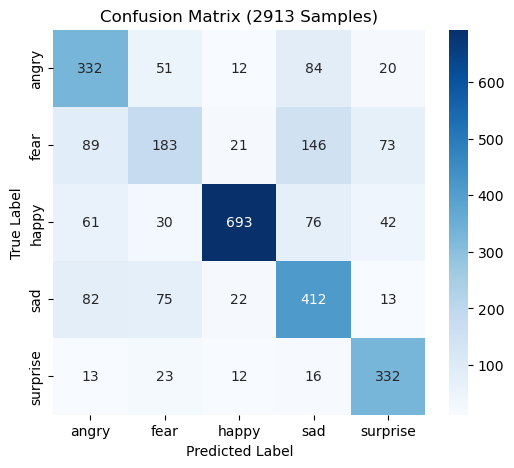

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Carico il modello precedentemente addestrato 
model = load_model('model_complete_prova_6.h5')

# Funzione per ottenere le predizioni del modello sui dati di test
def get_predictions_from_generator(model, test_generator, max_samples=2913):
    true_labels = []   # Lista per memorizzare le etichette reali
    pred_labels = []   # Lista per memorizzare le etichette predette dal modello
    
    count = 0
    for img_batch, label_batch in test_generator:   # Itera sui batch del test set
        if count >= max_samples:
            break
        
        batch_size = img_batch.shape[0]   # Ottiene la dimensione del batch corrente
        if count + batch_size > max_samples:
            batch_size = max_samples - count   # Adatta il batch per non superare il limite massimo di campioni
           
        
        # Ottiene le previsioni del modello sul batch corrente
        predictions = model.predict(img_batch[:batch_size])  
        
        # Converte le probabilità in classi predette (indice della classe con probabilità massima)
        pred_labels.extend(np.argmax(predictions, axis=1))  
        
        # Ottiene le classi reali corrispondenti agli esempi nel batch
        true_labels.extend(np.argmax(label_batch[:batch_size], axis=1)) 
        
        count += batch_size   # Aggiorna il numero totale di campioni elaborati
    
    # Restituisce gli array con le etichette reali e predette
    return np.array(true_labels), np.array(pred_labels)


# Ottieni le predizioni e le etichette vere (fino a 2913 campioni)
true_labels, pred_labels = get_predictions_from_generator(model, test_generator, max_samples=2913)



# Calcola la Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Ottieni i nomi delle classi dal generatore
class_names = list(test_generator.class_indices.keys())

# Visualizza la Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (2913 Samples)")
plt.show()


In [19]:
# Stampa il report di classificazione con metriche di valutazione (precision, recall, F1-score)
print("\nClassification Report (2913 Samples):")
print(classification_report(true_labels, pred_labels, target_names=class_names))


from sklearn.metrics import accuracy_score
# Accuracy finale del modello 
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score

# Precision (media semplice tra le classi)
precision = precision_score(true_labels, pred_labels, average="macro")


print(f"Precision : {precision:.4f}")



Classification Report (2913 Samples):
              precision    recall  f1-score   support

       angry       0.58      0.67      0.62       499
        fear       0.51      0.36      0.42       512
       happy       0.91      0.77      0.83       902
         sad       0.56      0.68      0.62       604
    surprise       0.69      0.84      0.76       396

    accuracy                           0.67      2913
   macro avg       0.65      0.66      0.65      2913
weighted avg       0.68      0.67      0.67      2913

Accuracy: 0.6701
Precision : 0.6491


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


/var/folders/gq/bvv781yn5vx6lj6h56v__my80000gn/T/ipykernel_37004/4214003782.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


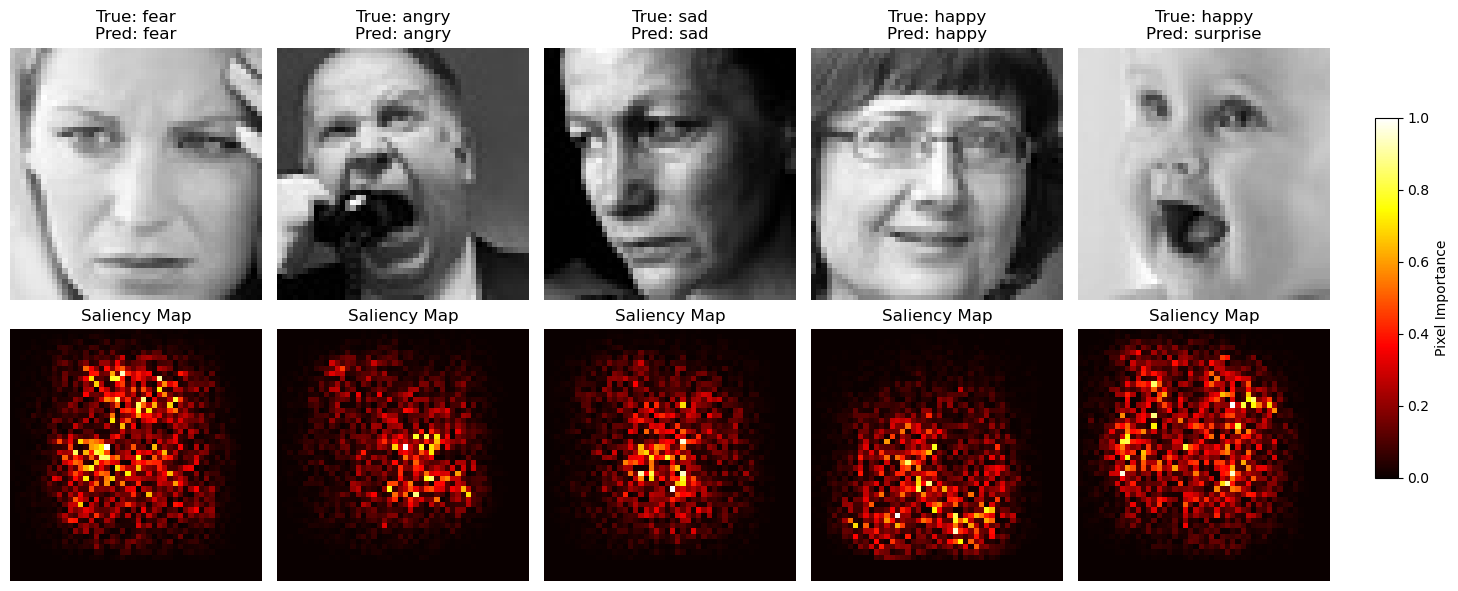

In [19]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Carico il modello precedentemente addestrato
model = load_model('model_complete_prova_6.h5')

# Ottengo i nomi delle classi dal test_generator
class_names = list(test_generator.class_indices.keys())

# Funzione per caricare 5 immagini casuali dal test set
def load_random_images_from_full_testset(test_generator, num_images=5):
    total_samples = test_generator.samples    # Numero totale di immagini nel test set
    batch_size = test_generator.batch_size  

    # Seleziona casualmente gli indici delle immagini da estrarre
    random_indices = random.sample(range(total_samples), num_images)

    images = []
    true_labels = []

    for random_index in random_indices:
        # Individuiamo in quale batch e in che posizione è l'immagine che abbiamo selezionato
        batch_index = random_index // batch_size  
        inside_batch_index = random_index % batch_size  

        # Estraiamo il batch corrispondente, l'immagine e la sua etichetta
        img_batch, label_batch = test_generator.__getitem__(batch_index)
        img_array = img_batch[inside_batch_index]
        true_label = np.argmax(label_batch[inside_batch_index])   # Converte la one-hot encoding in indice numerico


        images.append(img_array)
        true_labels.append(true_label)

    return np.array(images), np.array(true_labels)  # Array delle immagini estratte e delle loro etichette

# Funzione per calcolare la saliency map
def compute_saliency_map(model, img_array, class_index):
    img_array = tf.convert_to_tensor(img_array)    # Converte l'immagine in un tensore TensorFlow


    with tf.GradientTape() as tape:
        tape.watch(img_array)    # Abilita il calcolo del gradiente rispetto all'immagine
        predictions = model(img_array)    # Genera le previsioni del modello
        loss = predictions[:, class_index]    # Seleziona la probabilità della classe target

        
    gradient = tape.gradient(loss, img_array)  # Calcola il gradiente della previsione rispetto ai pixel dell'immagine
    
    
    # Estrae il massimo valore assoluto dei gradienti per poi normalizzare il colore della saliency map, dal pixel piu importante al meno importante
    saliency_map = tf.reduce_max(tf.abs(gradient), axis=-1)[0]
    saliency_map = saliency_map.numpy()  

    # Normalizzazione della saliency map tra 0 e 1
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map) + 1e-8)

    return saliency_map

# Seleziona 5 immagini casuali dal test set
img_arrays, true_labels = load_random_images_from_full_testset(test_generator, num_images=5)

# Crea le previsioni per le 5 immagini
predictions = model.predict(img_arrays)
predicted_labels = np.argmax(predictions, axis=1)

# Calcola la saliency map per ciascuna immagine
saliency_maps = [compute_saliency_map(model, np.expand_dims(img, axis=0), pred) 
                 for img, pred in zip(img_arrays, predicted_labels)]

# Visualizza le immagini e le saliency maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Immagine originale
    axes[0, i].imshow(img_arrays[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    axes[0, i].axis('off')

    # Saliency Map con barra colore
    saliency_plot = axes[1, i].imshow(saliency_maps[i], cmap='hot', vmin=0, vmax=1)  
    axes[1, i].set_title("Saliency Map")
    axes[1, i].axis('off')

# Aggiungi la colorbar a destra della figura per l'intensità della saliency map
cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
fig.colorbar(saliency_plot, cax=cbar_ax, label="Pixel Importance")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Migliora la disposizione dei grafici
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

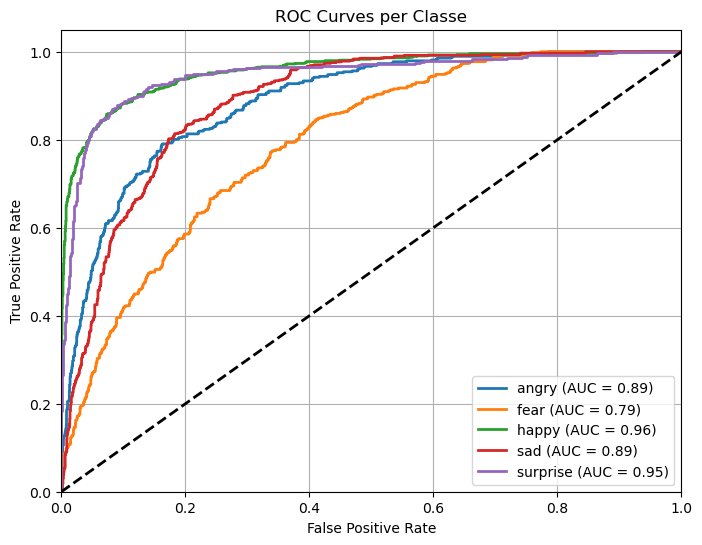

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import load_model

# Carica il modello salvato
model = load_model('model_complete_prova_6.h5')


# Funzione per ottenere le predizioni
# A differenza della funzione usata per la Confusion Matrix, qui restituiamo le probabilità 
# di ogni classe invece delle etichette predette, poiché successivamente le binarizzeremo.
def get_predictions_from_generator(model, test_generator, max_samples=2913):
    true_labels = []
    pred_probs = []    # Probabilità invece delle classi predette
    
    count = 0
    for img_batch, label_batch in test_generator:
        if count >= max_samples:
            break
        
        batch_size = img_batch.shape[0]
        if count + batch_size > max_samples:
            batch_size = max_samples - count  
        
        predictions = model.predict(img_batch[:batch_size])  
        pred_probs.extend(predictions)  
        true_labels.extend(label_batch[:batch_size])  
        
        count += batch_size
    
    return np.array(true_labels), np.array(pred_probs)

# Ottieni le etichette vere e le probabilità predette
true_labels, pred_probs = get_predictions_from_generator(model, test_generator, max_samples=2913)

# Binarizza le etichette reali (necessario per ROC curve multi-classe)
n_classes = pred_probs.shape[1]  # Numero di classi nel modello
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))  #Binarizza le etichette

# Colori per ogni classe
colors = sns.color_palette("tab10", n_classes)  

# Ottieni i nomi delle classi dal test_generator
class_names = list(test_generator.class_indices.keys())

# Disegna le ROC curve 
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])   # Calcola i valori FPR (False Positive Rate) e TPR (True Positive Rate)
    roc_auc = auc(fpr, tpr)  # Area sotto la curva (AUC) per ogni classe
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Linea diagonale (caso randomico)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Stile del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Classe")
plt.legend(loc="lower right")
plt.grid(True)

# Mostra il grafico
plt.show()

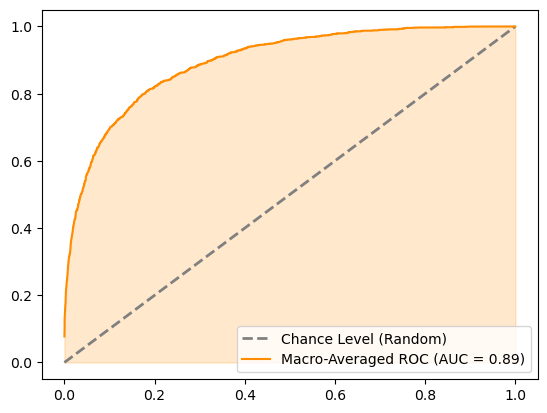

In [78]:
from sklearn.metrics import auc
import numpy as np

# Calcola la Macro-Averaged ROC (media delle curve ROC di tutte le classi)

# Estrae e unisce tutti i valori unici di False Positive Rate (FPR) dalle curve ROC di ogni classe
all_fpr = np.unique(np.concatenate([roc_curve(true_labels_bin[:, i], pred_probs[:, i])[0] for i in range(n_classes)]))
# Inizializza array per la media
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)  # Interpola le TPR su tutti i FPR

mean_tpr /= n_classes  # Media delle curve ROC
macro_auc = auc(all_fpr, mean_tpr)  # Calcola l'area sotto la curva (AUC) per la Macro-Averaged ROC

# Disegna la bisettrice casuale (chance level)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2, label="Chance Level (Random)")

# Disegna la Macro-Averaged ROC 
plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle="-", linewidth=1.5, label=f"Macro-Averaged ROC (AUC = {macro_auc:.2f})") 
plt.fill_between(all_fpr, mean_tpr, alpha=0.2, color="darkorange") 

plt.legend(loc="lower right") 


## Merging Classes and Binarizing the Classification

The network was trained on fine-grained classes, and now we want to **observe the effect of merging the class probabilities, transforming the problem into a binary classification task.**  
This also allows comparing the resulting performance with that obtained in the second notebook.




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━

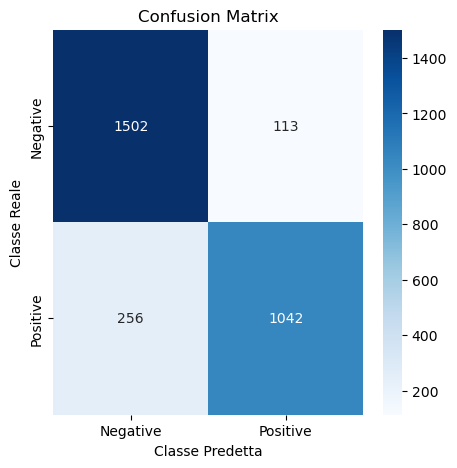

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import load_model

# Carica il modello salvato
model = load_model('model_complete_prova_6.h5')

# Funzione per ottenere le predizioni e le probabilità
def get_predictions_from_generator(model, test_generator, max_samples=2913):
    true_labels = []
    pred_probs = []  # Probabilità invece delle classi predette
    
    count = 0
    for img_batch, label_batch in test_generator:
        if count >= max_samples:
            break
        
        batch_size = img_batch.shape[0]
        if count + batch_size > max_samples:
            batch_size = max_samples - count  # Evita di superare max_samples
        
        predictions = model.predict(img_batch[:batch_size])  # Probabilità di ogni classe
        pred_probs.extend(predictions)  # Salva le probabilità
        true_labels.extend(label_batch[:batch_size])  # Etichette reali
        
        count += batch_size
    
    return np.array(true_labels), np.array(pred_probs)

# Ottieni le etichette vere e le probabilità predette dei dati di test
true_labels, pred_probs = get_predictions_from_generator(model, test_generator, max_samples=2913)

# Se le etichette sono in formato one-hot, convertilo in numeri interi 
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Mappiamo le classi originali a due classi
mapping = {0: 0, 1: 0, 3: 0,  # Classi 0,1,3 (angry, fear, sad)→ Nuova classe 0 (negative)
           2: 1, 4: 1}         # Classi 2,4 (happy, surprise)→ Nuova classe 1 (positive)

# Convertiamo le etichette vere nel nuovo formato binario
true_labels_bin = np.array([mapping[label] for label in true_labels])

# Calcoliamo le probabilità per la nuova classe 1 (sommando le classi 2 e 4)
prob_bin = np.sum(pred_probs[:, [2, 4]], axis=1)  

# Assegniamo le classi binarie in base alla soglia 0.5
pred_labels_bin = (prob_bin > 0.5).astype(int)  

# Calcoliamo la confusion matrix
conf_matrix = confusion_matrix(true_labels_bin, pred_labels_bin)


# Visualizziamo la Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Reale")
plt.title("Confusion Matrix")
plt.show()


In [33]:
# Stampare un report di classificazione
print("\nClassification Report (2913 Samples):")
print(classification_report(true_labels_bin, pred_labels_bin, target_names=["Negative", "Positive" ]))


# Calcoliamo accuracy e precision
accuracy = accuracy_score(true_labels_bin, pred_labels_bin)
precision = precision_score(true_labels_bin, pred_labels_bin)


# Stampa i risultati
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")


Classification Report (2913 Samples):
              precision    recall  f1-score   support

    Negative       0.85      0.93      0.89      1615
    Positive       0.90      0.80      0.85      1298

    accuracy                           0.87      2913
   macro avg       0.88      0.87      0.87      2913
weighted avg       0.88      0.87      0.87      2913

Accuracy: 0.8733
Precision: 0.9022


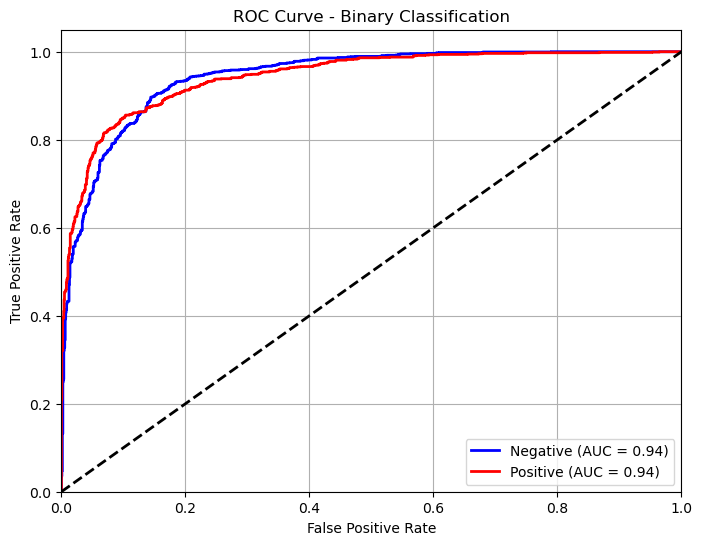

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Definizione delle classi binarie
class_names = ["Negative", "Positive"]
colors = ["blue", "red"]  # Colori per le due classi

# Creazione della curva ROC
plt.figure(figsize=(8, 6))

# ROC per la classe "Negative" (pos_label=0)
fpr_0, tpr_0, _ = roc_curve(true_labels_bin, 1 - prob_bin, pos_label=0)
roc_auc_0 = auc(fpr_0, tpr_0)
plt.plot(fpr_0, tpr_0, color=colors[0], lw=2, label=f"Negative (AUC = {roc_auc_0:.2f})")

# ROC per la classe "Positive" (pos_label=1)
fpr_1, tpr_1, _ = roc_curve(true_labels_bin, prob_bin, pos_label=1)
roc_auc_1 = auc(fpr_1, tpr_1)
plt.plot(fpr_1, tpr_1, color=colors[1], lw=2, label=f"Positive (AUC = {roc_auc_1:.2f})")

# Linea diagonale (caso randomico)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Stile del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary Classification")
plt.legend(loc="lower right")
plt.grid(True)

# Mostra il grafico
plt.show()


Macro-Average AUC: 0.94


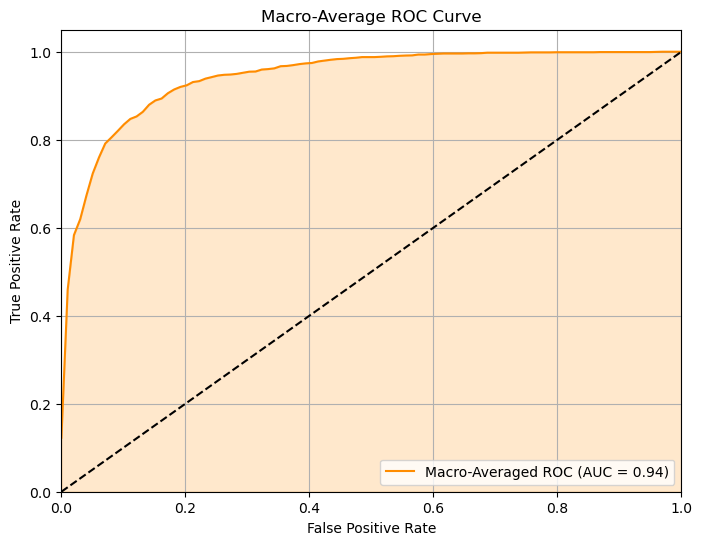

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

# Calcola la ROC per entrambe le classi
fpr_0, tpr_0, _ = roc_curve(true_labels_bin, 1 - prob_bin, pos_label=0)  # Classe "Negative"
fpr_1, tpr_1, _ = roc_curve(true_labels_bin, prob_bin, pos_label=1)  # Classe "Positive"

# Definiamo un range comune di FPR per interpolazione
all_fpr = np.linspace(0, 1, 100)

# Interpoliamo TPR per entrambe le classi
interp_tpr_0 = interp1d(fpr_0, tpr_0, kind="linear", bounds_error=False, fill_value=0)(all_fpr)
interp_tpr_1 = interp1d(fpr_1, tpr_1, kind="linear", bounds_error=False, fill_value=0)(all_fpr)

# Calcoliamo la media dei TPR
mean_tpr = (interp_tpr_0 + interp_tpr_1) / 2

# Calcoliamo l'AUC della macro-average ROC
macro_auc = auc(all_fpr, mean_tpr)
print(f"Macro-Average AUC: {macro_auc:.2f}")

# Disegniamo solo la Macro-Averaged ROC
plt.figure(figsize=(8, 6))

# Macro-Averaged ROC curve
plt.plot(all_fpr, mean_tpr, color="darkorange", linestyle="-", linewidth=1.5, label=f"Macro-Averaged ROC (AUC = {macro_auc:.2f})")
plt.fill_between(all_fpr, mean_tpr, alpha=0.2, color="darkorange")  # Area colorata in trasparenza

# Linea diagonale (caso randomico)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

# Stile del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Mostra il grafico
plt.show()


## Summary of the Model Used

In [8]:

from tensorflow.keras.models import load_model
model = load_model('model_complete_prova_6.h5')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,393,671 (5.32 MB)

 Trainable params: 1,391,429 (5.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 2 (12.00 B)

In [7]:
for layer in model.layers:
    if hasattr(layer, 'kernel_initializer'):
        print(f"Layer: {layer.name}, Inizializzatore: {layer.kernel_initializer}")


Layer: conv2d, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b06b110>
Layer: conv2d_1, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b096c10>
Layer: conv2d_2, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b0cb710>
Layer: conv2d_3, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b0e5590>
Layer: conv2d_4, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b12a350>
Layer: conv2d_5, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b14a3d0>
Layer: dense, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b1a4990>
Layer: dense_1, Inizializzatore: <keras.src.initializers.random_initializers.GlorotUniform object at 0x15b1da010>
